# Fully Connected Neural Networks

This tutorial demonstrates the usage of fully connected neural-networks to classify 2-dimensional synthetic data. We implement the network using Keras and TensorFlow. Keras and TensorFlow are powerful frameworks that allow you to build many  deep-learning-based applications.

The goals of this tutorial are:
  - Introduce Keras and TensorFlow to implement fully connected neural network.
  - Illustrate the non-linear decision rules that multi-layer neural networks can achieve.
  
      
## Importing Python Libraries

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

from tensorflow.keras.utils import to_categorical # Function to convert labels to one-hot encoding
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation,Input
from tensorflow.keras.optimizers import SGD

import sys
## Adding dataset_utils to the system path so we can import it
# MY_UTILS_PATH = '../Modules/'
# if not MY_UTILS_PATH in sys.path:
#     sys.path.append(MY_UTILS_PATH)
# import dataset_utils

import numpy as np

def spirals(N = 1000, degrees = 570, start = 90, noise = 0.2):
    """
    Generate "two spirals" dataset with N instances.
    Input:
    N -> Number of samples in the dataset
    degrees -> controls the length of the spirals
    start -> determines how far from the origin the spirals start, in degrees
    noise displaces the instances from the spiral. 0 is no noise, at 1 the
    spirals will start overlapping
    Output:
    data -> (Nx3) dataset: (xcoord,ycoord,label)
    """

    deg2grad = (2*np.pi)/360
    start = start*deg2grad

    #Number of samples in spirals 1 and 2
    N1 = int(np.floor(1.0*N/2))
    N2 = N - N1

    #Spiral 1
    n = start + np.sqrt(np.random.rand(N1,1))*degrees*deg2grad
    d1x =  -np.cos(n)*n + np.random.rand(N1,1)*noise
    d1y = np.sin(n)*n + np.random.rand(N1,1)*noise

    spiral1 = np.concatenate((d1x,d1y,\
                             np.zeros((N1,1))),axis = 1)

    # Spiral 2
    n = start + np.sqrt(np.random.rand(N2,1))*degrees*deg2grad
    d2x = np.cos(n)*n+np.random.rand(N2,1)*noise
    d2y = -np.sin(n)*n + np.random.rand(N2,1)*noise
    spiral2 = np.concatenate((d2x,d2y,\
                             np.ones((N2,1))),axis = 1)

    #Concatenating the final data
    data = np.concatenate((spiral1,spiral2),axis = 0)
    return data


def concentric_clusters(N = 1000, r1 = 1, r2 = 5, w1 = 0.8, w2 = 1.0/3, arms = 64):
    """
    Generates two concentric circular clusters.
    Input:
    N -> Number of samples in the dataset
    r1 -> Radius cluster 1
    r2 -> Radius cluster 2
    w1 -> Cluster 1 weight
    w2 -> Cluster 2 weight
    arms -> Number of stripes (arms) in the circle
    Output:
    data -> (Nx3) dataset: (xcoord,ycoord,label)
    """

    #Number of samples in each cluster
    N1 = int(np.floor(1.0*N/2))
    N2 = N - N1

    phi1 = np.random.rand(N1,1) * 2 * np.pi;
    dist1 = r1 + 1.0*(np.random.randint(0,5,size =(N1,1)))/5*w1*r1
    d1x = dist1* np.cos(phi1)
    d1y = dist1* np.sin(phi1)
    cluster1 = np.concatenate((d1x,d1y,\
                             np.zeros((N1,1))),axis = 1)

    perarm = int(np.round(N2/arms))
    N2 = perarm*arms;
    radperarm = (2*np.pi)/arms;
    phi2 = 1.0*(np.arange(1,N2+1,dtype = int) - np.arange(1,N2+1,\
            dtype=int)%perarm)/perarm*(radperarm)
    dist2 = r2 * (1 - w2/2) + (r2*w2*np.arange(1,N2+1,\
            dtype=int)%perarm)/perarm
    d2x = dist2*np.cos(phi2)
    d2y = dist2*np.sin(phi2)
    cluster2 = np.concatenate((d2x[:,np.newaxis],d2y[:,np.newaxis],\
                             np.ones((N2,1))),axis = 1)

    #Concatenating the final data
    data = np.concatenate((cluster1,cluster2),axis = 0)
    return data



def corners(N = 100,scale = 0,gapwidth = 2,cornerwidth = 2):
    """
    Generates for "corner" clusters .
    Input:
    N -> Number of samples in the dataset
    scale -> Corner scale
    gapwidth -> gap between corners
    cornerwidth -> corner width
    Output:
    data -> (Nx3) dataset: (xcoord,ycoord,label)
    """

    N = int(N/8)*8
    per_corner  = N//4

    xplusmin = np.concatenate((np.ones((per_corner,1)),\
                               -np.ones((per_corner,1)),\
                               np.ones((per_corner,1)),\
                               -np.ones((per_corner,1))),\
                               axis = 0)

    yplusmin = np.concatenate((np.ones((per_corner,1)),\
                               -np.ones((2*per_corner,1)),\
                               np.ones((per_corner,1))),\
                               axis = 0)

    #Horizontal edge
    x = xplusmin[::2]*gapwidth+xplusmin[::2]*scale*(np.random.rand(2*per_corner).reshape(-1,1))

    y = yplusmin[::2]*gapwidth + cornerwidth*yplusmin[::2]*(np.random.rand(2*per_corner).reshape(-1,1))

    z = np.floor(np.arange(2*per_corner,dtype = int)/(per_corner*0.5))

    horizontal = np.concatenate((x,y,z[:,np.newaxis]),axis = 1)

    # Vertical edge
    x2 = xplusmin[1::2]*gapwidth + cornerwidth*xplusmin[1::2]*\
                                 (np.random.rand(2*per_corner).reshape(-1,1))

    y2 = yplusmin[1::2]*gapwidth+yplusmin[1::2]*scale*\
                                 (np.random.rand(2*per_corner).reshape(-1,1))

    z2 = np.floor(np.arange(2*per_corner,dtype = int)/(per_corner*0.5))
    vertical = np.concatenate((x2,y2,z2[:,np.newaxis]),axis = 1)

    #Concatenating the final data
    data = np.concatenate((vertical,horizontal),axis = 0)
    return data



def crescent_full_moon(N = 1000,r1 = 5,r2 = 10,r3 = 15):
    """
    Generates 2 clusters. One shape as a full moon and the other as a crescent moon.
    Input:
    N -> Number of samples in the dataset
    r1 ->
    r2 ->
    r3 ->
    Output:
    data -> (Nx3) dataset: (xcoord,ycoord,label)
    """

    N = int(N/4)*4
    N1 = int(N/4)
    N2 = N-N1

    # Full moon
    phi1 = np.random.rand(N1,1)*2*np.pi
    R1 = np.sqrt(np.random.rand(N1, 1))
    moon = np.concatenate((np.cos(phi1)*R1*r1,np.sin(phi1)*R1*r1,\
                           np.zeros((N1,1))),axis = 1)
    # Crescent moon
    d = r3 - r2
    phi2 = np.pi + np.random.rand(N2,1)*np.pi
    R2 = np.sqrt(np.random.rand(N2,1))
    crescent = np.concatenate((np.cos(phi2)*(r2 + R2 * d),\
                               np.sin(phi2)*(r2 + R2 * d),\
                               np.ones((N2,1))),axis = 1)
    #concatenating the final data
    data = np.concatenate((moon,crescent),axis = 0)
    return data

## Loading and Displaying a Synthetic 2D Dataset

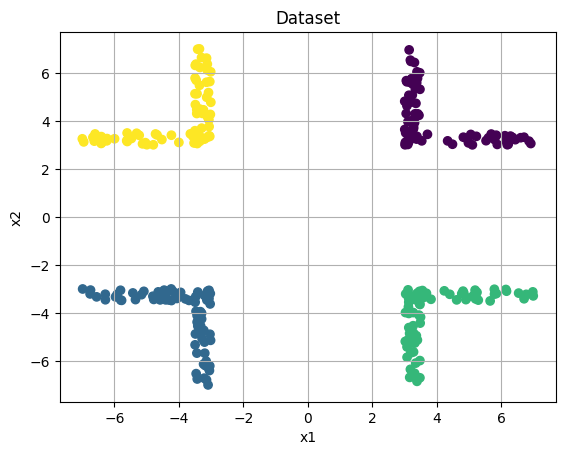

In [3]:
#Generating a synthetic dataset with four classes
nsamples = 300

data = corners(N = nsamples,scale = 0.5,gapwidth = 3,cornerwidth = 4) # linear dataset
#data = dataset_utils.crescent_full_moon(N = nsamples,r1 = 5,r2 = 10,r3 = 15) #non-linear dataset

# Separating features (X) and labels (Y)
Y = data[:,-1].astype(int) # Labels
X = data[:,:-1] # Features

#Number of classes
k = np.unique(Y).size

colors = np.array(['r','y','b','g'])
#Displaying the dataset
plt.scatter(X[:,0],X[:,1],c=Y)

plt.xlabel("x1")
plt.ylabel("x2")
plt.grid()
plt.title("Dataset")
plt.show()

## Train, Validation and Test Sets Split

In [5]:
# First we will shuffle the samples
indexes = np.arange(X.shape[0])
np.random.shuffle(indexes)
X = X[indexes,:]
Y = Y[indexes]

# Then, we split our data into train/val/test sets
train_split = int(0.5*Y.size)
val_split = int(0.75*Y.size)

X_train = X[:train_split,:]
Y_train = Y[:train_split]

X_val = X[train_split:val_split,:]
Y_val = Y[train_split:val_split]

X_test = X[val_split:,:]
Y_test = Y[val_split:]

## Data Normalization

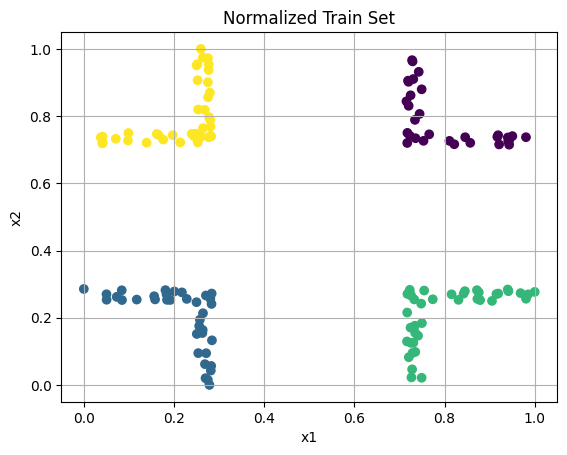

In [6]:
# min-max data normalization
x_train_min = X_train.min(axis = 0, keepdims = True)
x_train_max = X_train.max(axis = 0, keepdims = True)

X_train = (X_train - x_train_min)/(x_train_max - x_train_min)
X_val = (X_val - x_train_min)/(x_train_max - x_train_min)
X_test = (X_test - x_train_min)/(x_train_max - x_train_min)


#####################################################################################
#Activity suggestion:
# Change the min-max normalization above by standardization ((X - mean)/(std))
####################################################################################


#Displaying the normalized train set
plt.scatter(X_train[:,0],X_train[:,1],c=Y_train)
plt.xlabel("x1")
plt.ylabel("x2")
plt.grid()
plt.title("Normalized Train Set")
plt.show()

## Representing Labels using one-hot-ecoding

In [7]:
Y_oh_train = to_categorical(Y_train, k)
Y_oh_val = to_categorical(Y_val, k)
Y_oh_test = to_categorical(Y_test, k)
# Displaying the 5 first elemnts
print('Y_train[:5]:')
print(Y_train[:5])
print('\nY_oh_train[:5]=')
print(Y_oh_train[:5])

Y_train[:5]:
[1 3 0 2 2]

Y_oh_train[:5]=
[[0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]


## Defining a Fully Connected Neural Network with Keras

In [10]:
def my_model(k,learning_rate = 0.15):
    inputs = Input(shape=(2,))
    out1 = Dense(k, activation='softmax')(inputs)
    model = Model(inputs=inputs, outputs=out1)
    sgd = SGD(learning_rate=learning_rate)
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics = ["accuracy"])
    return model

In [11]:
model = my_model(k)
print(model.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │              12 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12 (48.00 B)

 Trainable params: 12 (48.00 B)

 Non-trainable params: 0 (0.00 B)

None


## Training the Model

In [13]:
batch_size = train_split
nb_epoch = 500
n = X_train.shape[0] # number of training examples
history = model.fit(X_train, Y_oh_train, validation_data=(X_val,Y_oh_val), \
                    batch_size=batch_size, epochs=nb_epoch,verbose=1)

Epoch 1/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.6419 - loss: 1.0726 - val_accuracy: 0.6351 - val_loss: 1.0850
Epoch 2/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6419 - loss: 1.0691 - val_accuracy: 0.6351 - val_loss: 1.0816
Epoch 3/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.6486 - loss: 1.0657 - val_accuracy: 0.6351 - val_loss: 1.0782
Epoch 4/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.6486 - loss: 1.0623 - val_accuracy: 0.6351 - val_loss: 1.0748
Epoch 5/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6486 - loss: 1.0589 - val_accuracy: 0.6351 - val_loss: 1.0714
Epoch 6/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6554 - loss: 1.0555 - val_accuracy: 0.6486 - val_loss: 1.0680
Epoch 7/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.6554 - loss: 1.0521 - val_accuracy: 0.6486 - val_loss: 1.0647
Epoch 8/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.6689 - loss: 1.0487 - val_accuracy: 0.6486 - val_loss:

## Prininting Loss and estimated weights (Ws)

Final loss (cross-entropy and accuracy): [0.3943505585193634, 1.0]

Layer 0
Bias:
 [-1.9613504   2.4203298  -0.41975504 -0.03922297]
W:
 [[ 2.186145  -2.3028202  3.716075  -3.317923 ]
 [ 2.244902  -2.3861792 -3.023072   3.3798728]]



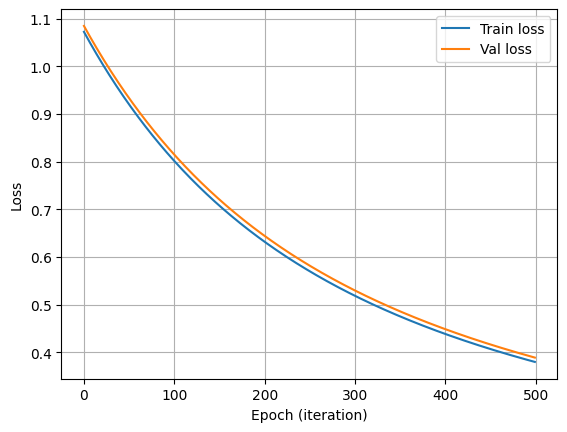

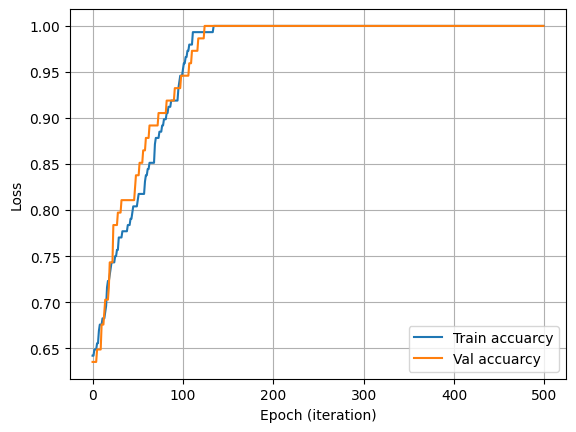

In [14]:
loss = model.evaluate(X_test, Y_oh_test, verbose=0)
print('Final loss (cross-entropy and accuracy):',loss)
print()
W = model.get_weights()
for ii in range(len(W)//2):
    print("Layer %d" %ii)
    print('Bias:\n', W[2*ii + 1])
    print('W:\n', W[2*ii])
    print()

plt.plot(history.history['loss'], label = "Train loss")
plt.plot(history.history['val_loss'], label = "Val loss")
plt.xlabel("Epoch (iteration)")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()


plt.plot(history.history['accuracy'], label = "Train accuarcy")
plt.plot(history.history['val_accuracy'], label = "Val accuarcy")
plt.xlabel("Epoch (iteration)")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

## Classifier Decision Boundary

117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


<ipython-input-15-794ffa8a6569>:18: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_train[:,0], X_train[:,1], c=colors[Y_train], edgecolors='k', cmap=plt.cm.Paired)


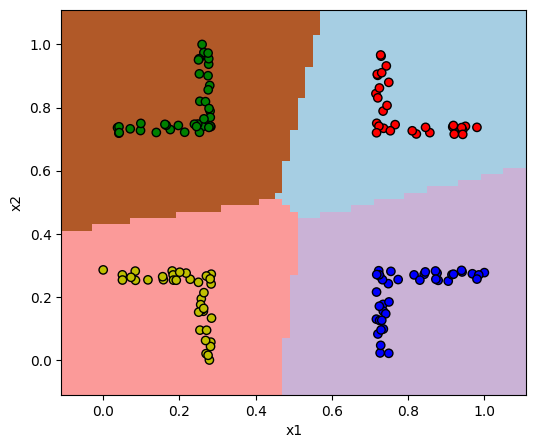

In [15]:
h = .02  # step size in the mesh
slack = 0.1
# Calcula a grade para o espaço de atributos

x_min, x_max = X_train.min(axis=0) - slack, X_train.max(axis=0) + slack
xx, yy = np.meshgrid(np.arange(x_min[0], x_max[0], h), np.arange(x_min[1], x_max[1], h))
X_grid = np.c_[xx.ravel(), yy.ravel()]

# Prediction of all samples in our grid
Z = model.predict(X_grid).argmax(axis = 1)
Z = Z.reshape(xx.shape)

# Display decision boundary
plt.figure(1, figsize=(6, 5))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Display training samples
plt.scatter(X_train[:,0], X_train[:,1], c=colors[Y_train], edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

## Suggested activities
- Repeat the example without normalizing the data or using standardization (i.e., subtract from the mean and divide by the standard-deviation);
- Experiment with other datasets
- Change the neural network architecture
- ...